### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

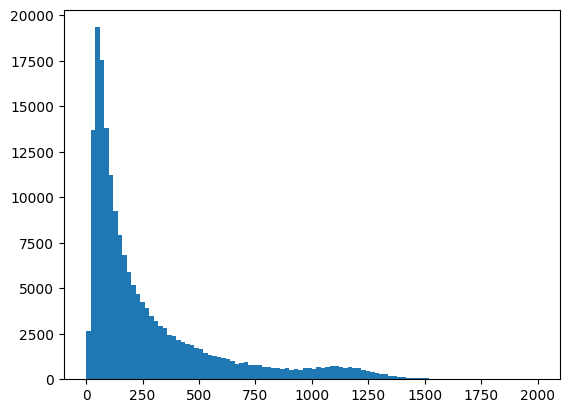

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [8]:
vectorized_texts = vectorize_layer(processed_texts)

In [9]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

In [10]:
vectorized_val_texts

<tf.Tensor: shape=(23208, 200), dtype=int64, numpy=
array([[  15,    1,  132, ...,    0,    0,    0],
       [ 339,   41,   23, ...,    0,    0,    0],
       [  12,    1,  466, ...,    0,    0,    0],
       ...,
       [ 227,    1, 2440, ...,    0,    0,    0],
       [ 766, 1770, 1919, ...,    0,    0,    0],
       [   3,   20,    3, ...,   49, 1188,    4]], dtype=int64)>

In [11]:
labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int16)

#### Model 1

In [12]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.Bidirectional(keras.layers.GRU(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(20)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 343s 58ms/step - accuracy: 0.9025 - loss: 0.2403 - val_accuracy: 0.9350 - val_loss: 0.1673
Epoch 2/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 333s 57ms/step - accuracy: 0.9422 - loss: 0.1519 - val_accuracy: 0.9401 - val_loss: 0.1580
Epoch 3/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 332s 57ms/step - accuracy: 0.9466 - loss: 0.1411 - val_accuracy: 0.9403 - val_loss: 0.1580
Epoch 4/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 330s 57ms/step - accuracy: 0.9500 - loss: 0.1323 - val_accuracy: 0.9397 - val_loss: 0.1607
Epoch 5/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 330s 57ms/step - accuracy: 0.9549 - loss: 0.1200 - val_accuracy: 0.9413 - val_loss: 0.1587
Epoch 6/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 330s 57ms/step - accuracy: 0.9580 - loss: 0.1144 - val_accuracy: 0.9400 - val_loss: 0.1625
Epoch 7/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 330s 57ms/step - accuracy: 0.9621 - loss: 0.1035 - val_accuracy: 0.9370 - val_loss: 0.1755
Epoch 8/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 332s 57ms/step - accuracy: 

##### Evaluating the Model

In [14]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [15]:
best_model = model

In [16]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 30)        │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 30)        │         4,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,273 (676.85 KB)

 Trainable params: 57,757 (225.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 115,516 (451.24 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9406 - loss: 0.1680


In [17]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0645
False Negative Rate: 0.0561
accuracy_score 0.940
precision_score 0.935
recall_score 0.944
f1_score 0.939


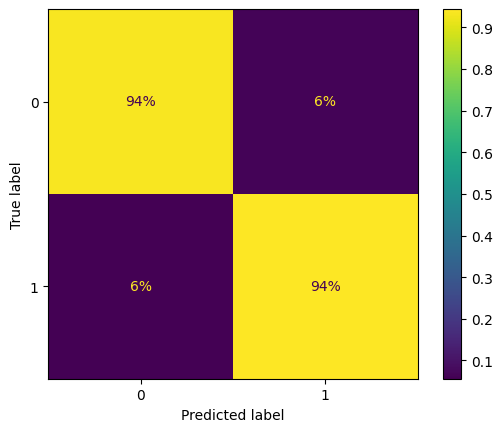

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()